In [1]:
from src.database import DatabaseXRD,snip,Phase,MixPhase
from src.gaussnewton import GaussNewton
from numpy import newaxis,loadtxt,diag,histogram,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

from src.spectra import Spectra

In [2]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]

In [3]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

In [4]:
files = glob('Cappello/Spinel_Barite/roi*.dat')
cnb_hcs = MixPhase([spinel,barite])

xrd_gn = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('Cappello/Calibrazione1.txt').convolve(1).snip()
    
    xrd_spectra += [spectra]
    xrd_gn += [GaussNewton(cnb_hcs,spectra)]

N mixtures: 102
[-1410.04773774    58.74246905  1770.33948876]
[-1410.03035414    58.74179056  1770.3576939 ]
[-1414.53321767    58.92916651  1764.72029361]
[-1407.05167788    58.61701081  1773.99663304]
[-1407.66338749    58.64080622  1773.41575119]
[-1422.79132045    59.25446973  1756.23852285]
[-1406.64776956    58.60106856  1774.6255955 ]
[-1406.6048939     58.59920076  1774.68584078]
[-1411.05748527    58.78313915  1769.1806893 ]
[-1404.45648678    58.50929412  1777.26715887]
[-1405.08547375    58.53367724  1776.67247522]
[-1419.54284037    59.1164885   1760.47856944]
[-1410.5028864     58.75981185  1769.87031178]
[-1410.50377862    58.7598453   1769.8695143 ]
[-1415.0380554     58.94866007  1764.18650163]
[-1407.53319793    58.63526929  1773.50583459]
[-1408.14163909    58.65894605  1772.92796978]
[-1423.28952669    59.27391045  1755.70125616]
[-1410.50310654    58.7598206   1769.87006634]
[-1410.50378453    58.75984552  1769.8695085 ]
[-1415.03808002    58.94866103  1764.1864759

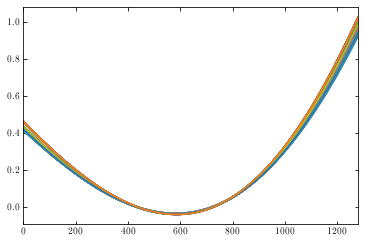

In [5]:
all_spinel = database['Spinel']
all_barite = database['Barite']
sb = []
for spinel in all_spinel:
    for barite in all_barite:
        sb += [MixPhase([spinel,barite])]
print('N mixtures:',len(sb))

x = arange(1280)
gn = []
for phase in sb:
    gn += [GaussNewton(phase,xrd_spectra[0])]
    
for g in gn[:]:
    for _ in range(64):
        g.calibration(alpha=1)
        g.opt = g.spectra.opt.copy()
    print(g.spectra.opt)
    
    opt = g.spectra.opt
    opt_file = g.spectra.opt_file
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)

NameError: name 's' is not defined

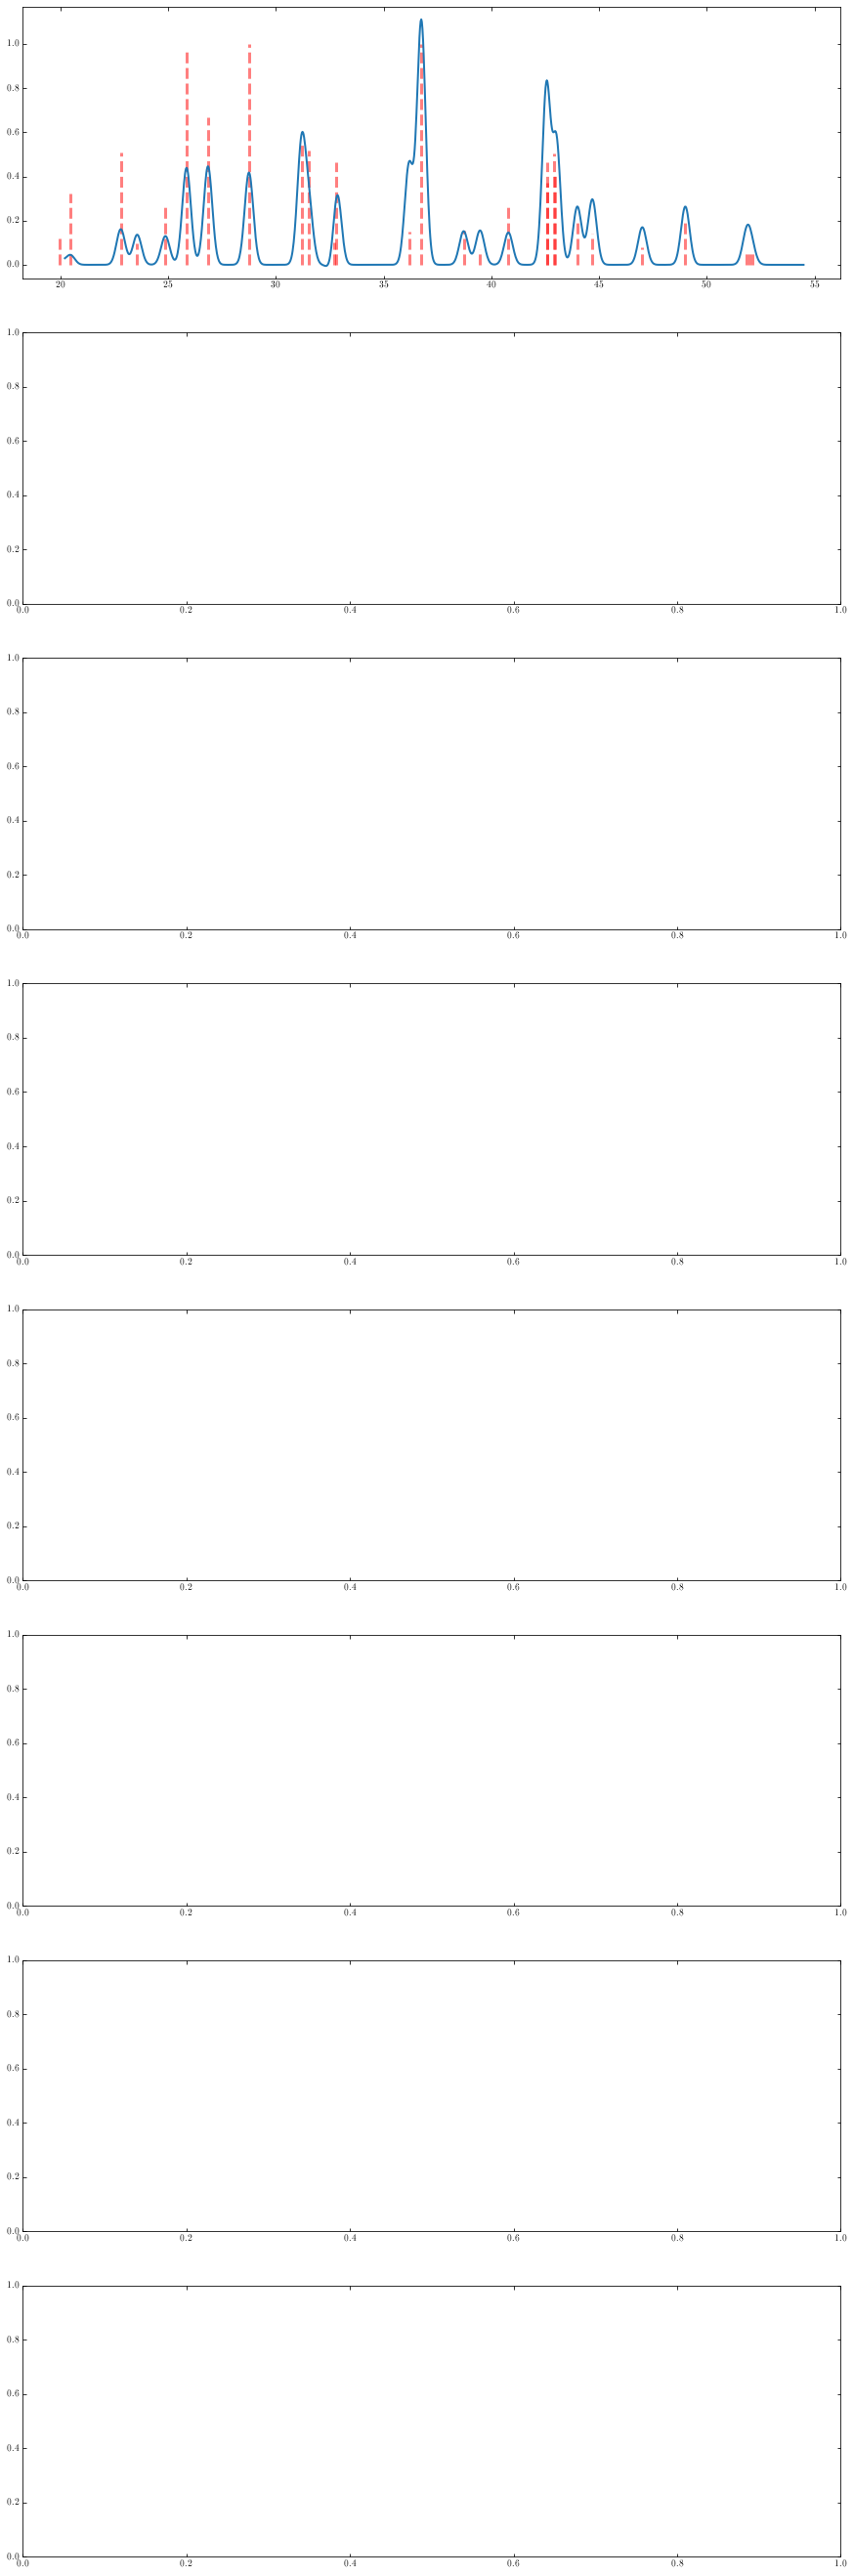

In [6]:
%matplotlib inline
fig,ax = subplots(8,1,figsize = (15,48))

for i,g in enumerate(gn[-8:]):
    
    g.spectra.opt = g.opt.copy()
    
    ax[i].vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
    ax[i].plot(g.theta,g.z,'-',lw=2)
    ax[i].plot(s.theta,s.intensity,'-.')
    ax[i].vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)
    
    ax[i].vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

In [ ]:
g = xrd_gn[0]
s = xrd_spectra[0]

for _ in range(32):
    g.calibration(alpha=1)  
print(g.gamma)

figure(figsize=(15,6))

vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(s.theta,s.intensity,'-.')
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)

xlim(19,53)
#ylim(0,1)

In [ ]:
%matplotlib inline
fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))

for i,(spectra,gn) in enumerate(zip(xrd_spectra,xrd_gn)):
    
    for _ in range(16):
        gn.calibration(alpha=0.5)
    print(gn.spectra.opt)
    
    ax[i].plot(spectra.theta,spectra.intensity)
    
    x,y = cnb_hcs.get_theta(max_theta = 53,min_intensity=0.05)
    ax[i].vlines(x,0,y,'k',lw=2)
    ax[i].vlines(x,0,1.0,'k',lw=1,ls='--',alpha=0.33)
        
    ax[i].plot(gn.theta,gn.z)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

In [ ]:
#fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))
figure(figsize=(15,6))

x = arange(0,1280)
for i,gn in enumerate(xrd_gn):
    opt = gn.spectra.opt
    opt_file = gn.spectra.opt_file
    print(opt,opt_file)
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)
